In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import tensorboard as tb

In [2]:
import torch
print(torch.backends.cudnn.version())


8302


In [3]:
# tensorflow import and cuda setup

import tensorflow as tf
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))


2023-12-19 04:36:56.703207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 04:36:56.755093: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found GPU at: /device:GPU:0


2023-12-19 04:36:57.418871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 04:36:57.449289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-19 04:36:57.450411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-19 04:36:57.451123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative val

In [4]:
print(torch.__version__)

1.12.1


In [5]:
print(torch.cuda.is_available())

True


In [6]:
#transforms
transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))]
)

# datasets
trainset = torchvision.datasets.FashionMNIST('/home/hslee/Desktop/Datasets',
                                             download=True,
                                             train=True,
                                             transform=transforms)
testset = torchvision.datasets.FashionMNIST('/home/hslee/Desktop/Datasets',
                                             download=True,
                                             train=False,
                                             transform=transforms)

In [7]:
# dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# image data shape
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [9]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [10]:
# helper functino to show an image

def matplotlib_imshow(img, one_channel=False) : 
    if one_channel :
        img = img.mean(dim = 0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel :
        plt.imshow(npimg, cmap='Greys')
    else :
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

In [11]:
class Net(nn.Module) :
    def __init__(self) : # Net Class에 대한 constructor에는
        super(Net, self).__init__()  # nn.Moudle의 constructor를 포함
        self.conv1 = nn.Conv2d(1, 6, 5) # (1, 28, 28) -> (6, 24, 24)
        self.pool = nn.MaxPool2d(2, 2) # (6, 24, 24) -> (6, 12, 12)
        self.conv2 = nn.Conv2d(6, 16, 5) # (6, 12, 12) -> (16, 8, 8)
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # (16 * 4 * 4) -> (120)
        self.fc2 = nn.Linear(120, 84) # (120) -> (84)
        self.fc3 = nn.Linear(84, 10) # (84) -> (10)
        
    def forward(self, x) :
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" 
writer = SummaryWriter('./runs/fashion_mnist_experiment_1')

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

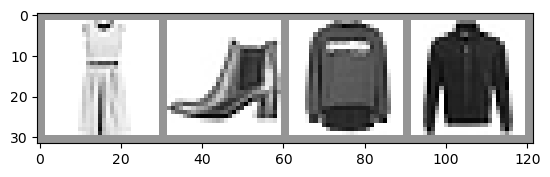

In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('4samples_fashion_mnist_images', img_grid)

In [15]:
writer.add_graph(net, images)
writer.close()

In [16]:
print(trainset.data.shape)
print(trainset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [17]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [18]:
def images_to_probs(net, images) :
    output = net(images)
    
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels) :
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

tensorboard --logdir=runs

In [19]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            # writer.add_figure('predictions vs. actuals',
            #                 plot_classes_preds(net, inputs, labels),
            #                 global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [22]:
class_probs = []
class_label = []

with torch.no_grad() :
    for data in testloader :
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        
        class_probs.append(class_probs_batch)
        class_label.append(labels)
        
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0) :
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    
    writer.close()
    
for i in range(len(classes)) :
    add_pr_curve_tensorboard(i, test_probs, test_label)
        